<a><img src="https://static.fibre2fashion.com/articleresources/images/33/3214/brazilian-cotton-production.jpg" width = 400></a>

<h1 align=center> <font size = 5>Phenology extraction methodology</font></h1>

In this script, phenology extraction pipeline is applied in python language. The processed data are mean NDVI time-series of parcels in the Thessaly region. The pre-process of the data includes a primary outlier detection via investigating the mean and standart deviation, making the assamption that the data follow a gaussian curve, and checking that every acqusition data are inside a mean+-3*standard deviation describing a 99.7% of the population. Furthermore weighted interpolation is applied to create decadal days from the acquisitions in order to produce a cloud-free, fixed timestep time-series. Polynomial interpolation follows to fill the empty decadal days and the outlier detection approach described above applied again. Moreover, linear interpolation is used to create daily time-series and savitzky golay filtering smooths the created ndvi curves. Finally, phenological metrics are extracted and the Start-End of Season are defined.

<h1 align=center><font size = 4> Table of Contents</font></h1>

<div class="alert alert-block alert-info" style="margin-top: 10px">

<font size = 3>
      
1. <a href="#section1">Load .csv time-series</a>   
2. <a href="#section2">Outlier detection using Normal Distribution propabilities</a>  
3. <a href="#section3">Primary Interpolation with Weighted Average and Polynomial fitting</a>  
4. <a href="#section4">Linear Interpolation to create daily values</a> 
5. <a href="#section5">Savitzky-Golay Smoothing</a> 
6. <a href="#section6">Apply Moving Average to detect Start/End of Season</a>
7. <a href="#section7">Calculate Phenological Metrics</a>
8. <a href="#section8">Validate results</a>

</font>
</div>

#### Import neccessary libraries for the implementation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import KMeans
from random import randint
from random import seed
from scipy.signal import savgol_filter
#from tslearn.clustering import TimeSeriesKMeans
import warnings
warnings.filterwarnings('ignore')

<a id='section1'></a>

### 1. Load .csv time-series

In [3]:
ndvi = pd.read_csv("C:/Users/User/Documents/NOA/e-shape/e-shape_Data/satellite_data_from_NOA/featurespace_object_NDVI_NewMask.csv", 
                       header=0).astype(int)
ndvi_sep = pd.read_csv("C:/Users/User/Documents/NOA/e-shape/e-shape_Data/satellite_data_from_NOA/featurespace_object_NDVI_NewMask2.csv",
                       header=0).astype(int)
ndvi_nov = pd.read_csv("C:/Users/User/Documents/NOA/e-shape/e-shape_Data/satellite_data_from_NOA/featurespace_object_NDVI_NewMask3.csv", 
                       header=0).astype(int)
ndvi_aug = pd.read_csv("C:/Users/User/Documents/NOA/e-shape/e-shape_Data/satellite_data_from_NOA/featurespace_object_NDVI_NewMaskAugust.csv", 
                       header=0).astype(int)

In [4]:
ndvi.columns.values[1:] = [19,29,39,59,69,74,79,89,94,99,104,109,114,119,124,129,134,139,144,149,154,159,164,169,174,179,184,
                           189,194,199,209,214,219,229,264,274,279,284,289,294,299,304,319,354,364]
ndvi_sep.columns.values[1:] = [244, 249, 254, 259 ,264, 269] #Set columns to DOY
del ndvi_sep['id']
ndvi_aug.columns.values[1:] = [224, 234] #Set columns to DOY
del ndvi_aug['id']
ndvi = ndvi.drop([264], axis=1)
ndvi_nov.columns.values[1:] = [314, 334]
del ndvi_nov['id']
ndvi = pd.concat([ndvi,ndvi_aug,ndvi_sep,ndvi_nov], axis=1)
obj_id = ndvi.id
del ndvi['id']
ndvi = ndvi.sort_index(axis=1)

#### Pre-process Dataset

In [5]:
#ndvi = ndvi.drop([154], axis=1)
ndvi = ndvi.drop([269], axis=1) #Drop burned images
ndvi = ndvi.drop([334], axis=1)
ndvi = ndvi.replace(-9999999, -999999)
ndvi = ndvi.replace(np.nan, -999999)
new_days = ["2018-01-10", "2018-01-20", "2018-01-30", "2018-02-10", "2018-02-20", "2018-02-28","2018-03-10", "2018-03-20", 
            "2018-03-30", "2018-04-10", "2018-04-20", "2018-04-30", "2018-05-10", "2018-05-20", "2018-05-30", "2018-06-10", 
            "2018-06-20", "2018-06-30", "2018-07-10", "2018-07-20", "2018-07-30", "2018-08-10", "2018-08-20", "2018-08-30", 
            "2018-09-10", "2018-09-20", "2018-09-30", "2018-10-10", "2018-10-20", "2018-10-30", "2018-11-10", "2018-11-20",
            "2018-11-30","2018-12-10","2018-12-20","2018-12-30"]
ndvi = ndvi.T
ndvi.index.name = 'doys' #Create decadal dates to have a fixed timestep
ndvi.reset_index(inplace=True)
nd = list()
for i in range(len(new_days)):
    nd.append(datetime.strptime(new_days[i], '%Y-%m-%d').timetuple().tm_yday)
ndvi=ndvi[1:ndvi.shape[0]]

(0.0, 1000.0)

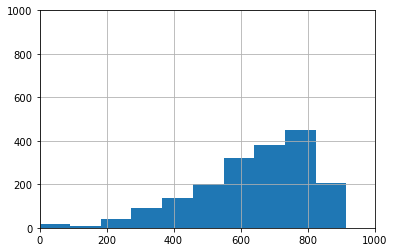

In [6]:
ndvi = ndvi.replace( -999999, np.nan)
ndvi.iloc[33,1:].hist()
plt.xlim(0,1000)
plt.ylim(0,1000)

<a id='section2'></a>

(0.0, 1000.0)

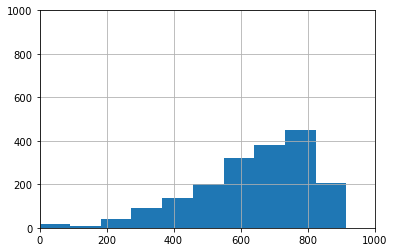

In [7]:
ndvi = ndvi.replace(-999999, np.nan)
ndvi.iloc[33,1:].hist()
plt.xlim(0,1000)
plt.ylim(0,1000)

### 2. Outlier detection per acquisition using Normal Distribution propabilities

In [8]:
ndvinn = ndvi.drop(['doys'], axis=1)
ndvinn.index = ndvi.doys
ndvinn = ndvinn.replace(-999999, np.nan)
ndvinn = ndvinn.replace(-9999999, np.nan)

In [9]:
# #Check that there is no peak before June
# l=np.zeros(shape=(ndvinn.shape[1],1))
# for i in range(ndvinn.shape[1]):
#     l[i,:] = np.nanmax(ndvinn.iloc[:17,i])

# l = pd.DataFrame(l)
# ndvinn = ndvinn.iloc[:,np.isin(np.array(ndvinn.columns),np.array(l[(l >= 400).all(axis=1)].index))==False]

In [10]:
l=np.zeros(shape=(ndvinn.shape[0],2))
for i in range(ndvinn.shape[0]):
    l[i,0] = np.nanstd(ndvinn.iloc[i,:])
    l[i,1] = np.nanmean(ndvinn.iloc[i,:])
l = pd.DataFrame(l)
l.columns = ['std_l','mean_l']

#Find 99.7 of the data that are within +- 3std
l['lower_limit'] = (l.mean_l-3*l.std_l)
l['upper_limit'] = (l.mean_l+3*l.std_l)
l = pd.DataFrame(l)
l.index = ndvinn.index

In [11]:
outliers = []
for i in range(ndvinn.shape[0]):
    for j in range(ndvinn.shape[1]):
        if((ndvinn.iloc[i,j]<l.iloc[i,2]) or (ndvinn.iloc[i,j]>l.iloc[i,3])):
            outliers.append(ndvinn.iloc[i,j])
            ndvinn.iloc[i,j] = np.nan
print('--- Number of total outliers found: %s ---'%len(outliers))

--- Number of total outliers found: 2622 ---


In [12]:
# ndvinn.loc[234,:].hist()
# a=835
# plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')
# plt.xticks(list(np.array(ndvinn.index)))
# #plt.xlim(150,300)
# plt.plot(ndvinn.iloc[:,a], marker='o', markerfacecolor='orange', color='orange')

In [13]:
ndvinn.insert (0, 'doys', ndvinn.index)
ndvinn.index = range(0,ndvinn.shape[0])
ndvinn = ndvinn.replace(np.nan,-999999)
ndvi = ndvinn.copy()

<a id='section3'></a>

### 3. Primary Interpolation with Weighted Average and Polynomial fitting

In [14]:
ndvi = ndvi.replace(np.nan,-999999)
#Weighted Average Interpolation, search +-5 days to find the reference days 
#from which the new dates will be created
l = np.zeros(ndvi.shape[0])
for i in range(ndvi.shape[0]):
    for j in range(len(nd)):
        x = ndvi.iloc[i,0]
        y = nd[j]
        if (abs(x-y) <= 5):
            l[i] = y
ndvi = pd.concat([ pd.DataFrame(l),ndvi.reset_index(drop=True)], axis=1)
ndvi.columns.values[0] = 'ref'
del new_days,nd

In [15]:
colnames = ndvi.columns.values
def interp_weight (df):
    dfn = np.zeros(shape=(df.shape[0],df.shape[1]))    
    #colnames = df.columns.values
    i = 0
    while (i <= (df.shape[0]-1)):
        if (i == (df.shape[0]-1)):
            dfn[i,:] = df[i,:] #When i becomes the last row then import the last row
            i=i+1
        elif (df[i,0] != df[i+1,0]):
            dfn[i,:] = df[i,:] #If value of ref at i is different at value of ref at i+1 then import the i line 
            i=i+1        
        else:
            if (df[i,0] == df[i,1]): #If value of ref at i is equal to value of doys at the same line i then import i line
                dfn[i,:] = df[i,:]
                i=i+2
            elif (df[i+1,0] == df[i+1,1]): #If value of ref at i+1 is equal to value of doys at the i+1 line import i+1 line 
                dfn[i,:] = df[i+1,:]
                i=i+2
            else:
                diff = df[i+1,1] - df[i,1]
                dist = abs(df[i,1] - df[i,0])
                w = (diff-dist)/diff
                df[i,:][df[i,:]==(-999999)] = df[i+1,:][df[i,:]==(-999999)]
                df[i+1,:][df[i+1,]==(-999999)] = df[i,:][df[i+1,:]==(-999999)]
                new_row = w*df[i,:] + (1-w)*df[i+1,] 
                dfn[i,:] = new_row
                i = i + 2    
    #dfn.columns = colnames
    return pd.DataFrame(dfn)

In [16]:
ndvi = np.array(ndvi)
ndvi = interp_weight(ndvi)
ndvi.columns = colnames
ndvi = ndvi.replace(-999999.0000000001, np.nan)
ndvi = ndvi.replace(-999999.0, np.nan)
ndvi = ndvi.drop(['doys'], axis=1)
del colnames
d = list()
for i in range(ndvi.shape[0]):
    if (ndvi.iloc[i,0]==0):
        d.append(i)      
ndvi = ndvi.drop(d, axis=0)  
del d

In [17]:
ndvi.index = ndvi.ref
ndvi = ndvi.drop(['ref'], axis=1)

In [18]:
ndvin = ndvi.copy()

In [19]:
polynomial = np.zeros(shape=ndvin.shape)
obj_id = np.array(ndvin.columns)
#Apply Polynomial Interpolation second order, replace timeseries with less than 3 values with nan to remove them afterwards
time_with_less = []
for i in range(ndvin.shape[1]):
    if (len(ndvin.iloc[:,i].unique())>3):
        polynomial[:,i] = ndvin.iloc[:,i].interpolate(method ='polynomial', order=2).ffill().bfill()
    else:
        time_with_less.append(ndvin.columns[i])
        polynomial[:,i] = np.nan
print('Found %s timeseries with less than 3 values' %len(time_with_less))
polynomial = pd.DataFrame(polynomial)
polynomial.index = ndvin.index

Found 422 timeseries with less than 3 values


(0.0, 1000.0)

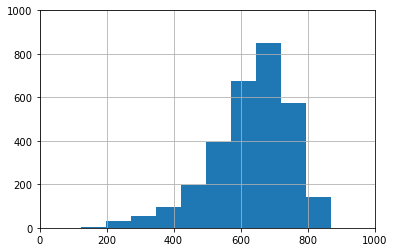

In [20]:
polynomial.loc[253,:].hist()
plt.xlim(0,1000)
plt.ylim(0,1000)

In [21]:
###Apply again Outlier Detection with Normal Distribution
l = np.zeros(shape=(polynomial.shape[0],2))
for i in range(polynomial.shape[0]):
    l[i,0] = np.nanstd(polynomial.iloc[i,:])
    l[i,1] = np.nanmean(polynomial.iloc[i,:])
l = pd.DataFrame(l)
l.columns = ['std_l','mean_l']

#Find 99.7 of the data that are within +- 3std
l['lower_limit'] = (l.mean_l-3*l.std_l)
l['upper_limit'] = (l.mean_l+3*l.std_l)
l = pd.DataFrame(l)
l.index = polynomial.index

In [22]:
outliers = []
for i in range(polynomial.shape[0]):
    for j in range(polynomial.shape[1]):
        if((polynomial.iloc[i,j]<l.iloc[i,2]) or (polynomial.iloc[i,j]>l.iloc[i,3])):
            outliers.append(polynomial.iloc[i,j])
            polynomial.iloc[i,j] = np.nan 
print('--- Number of total outliers found: %s ---'%len(outliers))

--- Number of total outliers found: 1410 ---


(0.0, 1000.0)

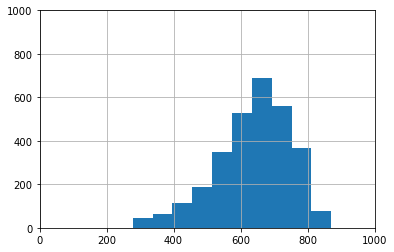

In [23]:
polynomial.loc[253,:].hist()
plt.xlim(0,1000)
plt.ylim(0,1000)

<a id='section4'></a>

### 4. Linear Interpolation to create daily values

In [24]:
new_doys = list(range(0,365))
old_doys = np.array(polynomial.index)
new_doys = np.array(new_doys)
ndvin = np.zeros(shape=(len(new_doys),polynomial.shape[1]))
ndvin[ndvin == 0] = 'nan'
for i in range(ndvin.shape[0]):
    if (i in old_doys):
        ndvin[i,:] = polynomial.loc[polynomial.index==i,:]
#ndvin[:,0] = range(0,365)
ndvin = pd.DataFrame(ndvin)
#ndvin.columns = obj_id
print('---Drop %s from %s timeseries with less than 3 values---' %(len(time_with_less) ,ndvin.shape[1]))

#ids = np.setdiff1d(np.union1d(obj_id, time_with_less), np.intersect1d(obj_id, time_with_less))
ndvin = ndvin.dropna(axis='columns', how='all')

---Drop 422 from 3441 timeseries with less than 3 values---


In [25]:
linear = np.zeros(shape=ndvin.shape)

for i in range(ndvin.shape[1]):
    linear[:,i] = ndvin.iloc[:,i].interpolate(method ='linear', axis=0).ffill().bfill()

linear = pd.DataFrame(linear)
linear.columns = ndvin.columns

<a id='section5'></a>

### 5. Savitzky-Golay Smoothing

In [26]:
#Apply savitzky goley filtering, as it captures both subtle and rapid changes in the time-series, 
#providing a better understanding for the beginning and for the ending of the growing season

savitzky = np.zeros(shape=linear.shape)
for i in range(savitzky.shape[1]):
    savitzky[:,i] = savgol_filter(np.array(linear.iloc[0:,i]).reshape(linear.shape[0]),mode='nearest', 
                                  window_length = 51, polyorder = 4)
savitzky = pd.DataFrame(savitzky)
savitzky.index = range(0,savitzky.shape[0])

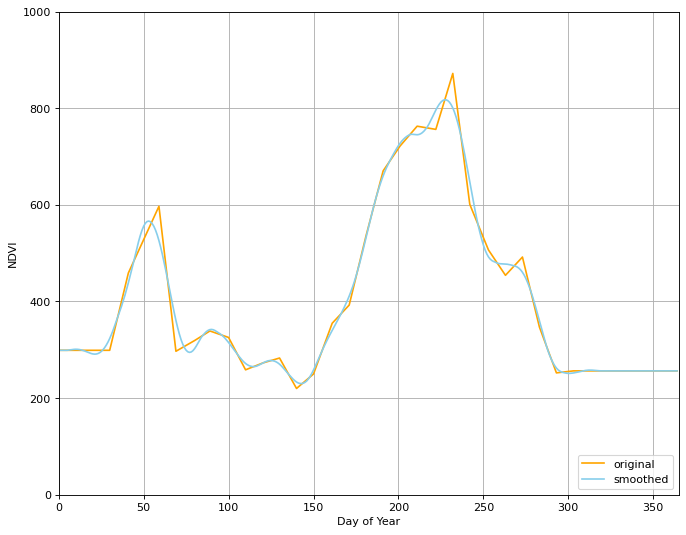

In [27]:
a=4
df1 = savitzky.iloc[0:,a].copy()
df2 = linear.iloc[0:,a].copy()
plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df2, marker=None, markerfacecolor='orange', color='orange', label='original')
plt.plot(df1, marker=None, markerfacecolor='skyblue', color='skyblue', label='smoothed')
plt.xlim(0,365)
plt.ylim(0,1000)
plt.grid()
plt.xlabel('Day of Year')
plt.ylabel('NDVI')
plt.legend(loc='lower right')

In [28]:
ndvi = savitzky.copy()

---Number of selected cluster is 477 ---


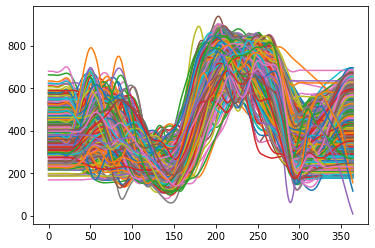

In [30]:
a=1
ndvin = np.asarray(ndvi.T).reshape(ndvi.T.shape[0],ndvi.T.shape[1],1)
km = TimeSeriesKMeans(n_clusters=5, metric="euclidean", max_iter=5, random_state=78).fit(ndvin)
ndvin = pd.DataFrame(ndvin.reshape(ndvi.T.shape[0],ndvi.T.shape[1]))
ndvin['label'] = km.labels_
ndvin = ndvin[ndvin.label==a].T
ndvin.iloc[:-1,:].plot(kind='line',legend=False)
print('---Number of selected cluster is %s ---'% len(ndvin.columns))

In [31]:
#Select one cluster
ndvi = ndvin.copy()
ndvi = ndvi.T.iloc[:,:-1].T

In [32]:
#Calculate local minima around peak value in order to define lag of moving average and therefore start/end of season
t_left_min = np.zeros(shape=(ndvi.shape[1],2))
t_right_min = np.zeros(shape=(ndvi.shape[1],2))

for i in range(ndvi.shape[1]):
#    print(i)
    if (ndvi.iloc[:,i].mean()>0):
        t_left_min[i,1] = ndvi.iloc[100:int(ndvi.iloc[:,i].idxmax()),i].min() #120
        t_left_min[i,0] = ndvi.iloc[100:int(ndvi.iloc[:,i].idxmax()),i].idxmin()
        
        t_right_min[i,1] = ndvi.iloc[int(ndvi.iloc[:,i].idxmax()):330,i].min()
        t_right_min[i,0] = ndvi.iloc[int(ndvi.iloc[:,i].idxmax()):330,i].idxmin()
    
t_left_min = pd.DataFrame(t_left_min)
t_right_min = pd.DataFrame(t_right_min)

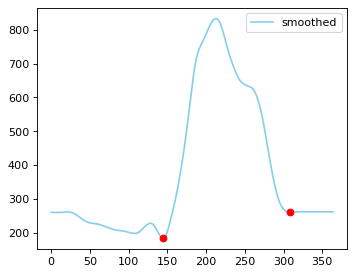

In [33]:
a=710
df1 = ndvi.iloc[0:,a]
plt.figure(num=None, figsize=(5,4), dpi=80, facecolor='w', edgecolor='k')

plt.plot(df1, marker=None, markerfacecolor='skyblue', color='skyblue', label='smoothed')
plt.plot(t_left_min.iloc[a,0],t_left_min.iloc[a,1], marker='o', color='red')
plt.plot(t_right_min.iloc[a,0],t_right_min.iloc[a,1], marker='o', color='red')

plt.legend()

In [34]:
mstd_area = np.zeros(shape=(ndvi.shape[1],2))
for i in range(ndvi.shape[1]):
    if (ndvi.iloc[:,i].mean()>0):
        mstd_area[i,0] = np.mean(np.array(ndvi.iloc[(ndvi.index>=t_left_min.iloc[i,0]) & (ndvi.index<=t_right_min.iloc[i,0]),i].index))
        mstd_area[i,1] = np.std(np.array(ndvi.iloc[(ndvi.index>=t_left_min.iloc[i,0]) & (ndvi.index<=t_right_min.iloc[i,0]),i].index))
    else:
        mstd_area[i,0] = 0
        mstd_area[i,1] = 0
mstd_area = pd.DataFrame(mstd_area)
mstd_area.columns = ['mean','std']

In [35]:
t_min = pd.concat([t_left_min,t_right_min], axis=1)
t_min.columns = ['left_min_doy','left_min_val','right_min_doy','right_min_val']
t_min = pd.concat([t_min,mstd_area], axis=1)
t_min['SLE'] = np.round(t_min.iloc[:,5]*2,0)
t_min['lag'] = np.round(ndvi.shape[0] - t_min.iloc[:,6],0)
#t_min.lag = pd.DataFrame(np.round(t_min.lag/10,0))

In [36]:
ndvi = pd.concat([ndvi,ndvi,ndvi], axis=0)
ndvi.index = range(0,ndvi.shape[0])

<a id='section6'></a>

### 6. Apply Moving Average to detect Start/End of Season

In [37]:
rolling_mean_forw = np.zeros(shape = ndvi.shape)
rolling_mean_back = np.zeros(shape = ndvi.shape)
typew = 'boxcar'
#int(t_min.iloc[i,7])
#min_periods=1
for i in range(ndvi.shape[1]):
    rolling_mean_forw[:,i] = ndvi.iloc[:,i].rolling(window=int(t_min.iloc[i,7]), win_type=typew).mean()
    rolling_mean_back[:,i] = ndvi.iloc[:,i][::-1].rolling(window=int(t_min.iloc[i,7])).mean()[::-1].shift()

rolling_mean_forw = pd.DataFrame(rolling_mean_forw)
rolling_mean_back = pd.DataFrame(rolling_mean_back)

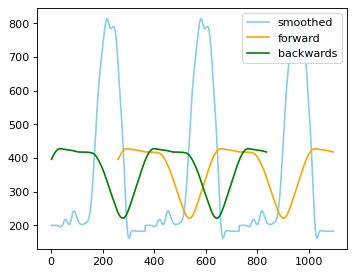

In [38]:
a=15
plt.figure(num=None, figsize=(5,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(ndvi.iloc[:,a], marker=None, markerfacecolor='skyblue', color='skyblue', label='smoothed')
plt.plot(rolling_mean_forw.iloc[:,a], color='orange', label='forward')
plt.plot(rolling_mean_back.iloc[:,a], color='green', label='backwards')
plt.legend()

In [39]:
ndvi = ndvi.iloc[365:730,:]
ndvi.index = range(0,ndvi.shape[0])
rolling_mean_forw = rolling_mean_forw.iloc[365:730,:]
rolling_mean_forw.index = range(0,rolling_mean_forw.shape[0])
rolling_mean_back = rolling_mean_back.iloc[365:730,:]
rolling_mean_back.index = range(0,rolling_mean_back.shape[0])

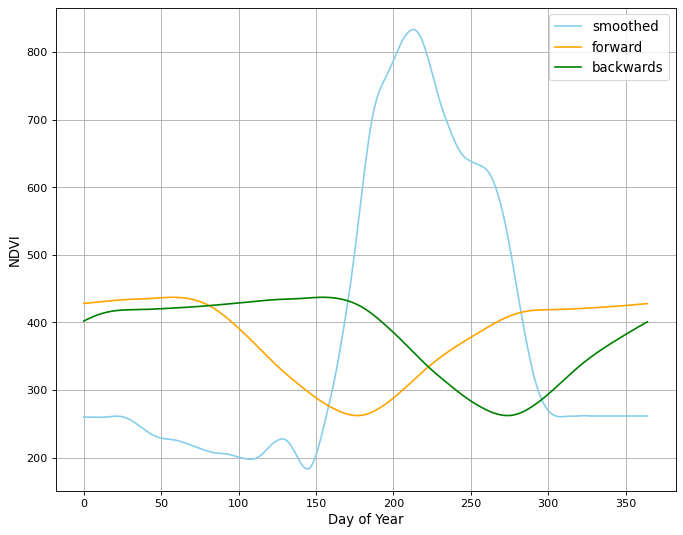

In [74]:
a=710
plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(ndvi.iloc[:,a], marker=None, markerfacecolor='skyblue', color='skyblue', label='smoothed')
plt.plot(rolling_mean_forw.iloc[:,a], color='orange', label='forward')
plt.plot(rolling_mean_back.iloc[:,a], color='green', label='backwards')
plt.xlabel('Day of Year',fontsize=12)
plt.ylabel('NDVI', fontsize=12)
plt.legend(fontsize = 12)
plt.grid()
plt.savefig('forwards-backwards.png', dpi=100)

In [55]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

The start (SOS), peak (POS) and end (EOS) of season are determined, as mentioned before, as the intersections of the reference time-series and the forward and backward lagged moving average curves respectively measured in Days of Year (DOY).

In [56]:
#Calculate phenological metrics
pheno_metrics = np.zeros(shape=(ndvi.shape[1],3))

for i in range(ndvi.shape[1]):
    if (ndvi.iloc[:,i].mean()>0):
        int_f = np.argwhere(np.diff(np.sign(ndvi.iloc[:,i] - rolling_mean_forw.iloc[:,i]))).flatten()
        int_f = int_f[(int_f>110) & (int_f<200)]
        if (int_f.size!=0):
            pheno_metrics[i,0] = np.array(int_f[len(int_f)-1])
        
        pheno_metrics[i,1] = ndvi.iloc[:,i].idxmax()
        
        int_b = np.argwhere(np.diff(np.sign(ndvi.iloc[:,i] - rolling_mean_back.iloc[:,i]))).flatten()
        int_b = int_b[(int_b>250) & (int_b<360)]
        if (int_b.size!=0):
            pheno_metrics[i,2] = np.array(int_b[0])

pheno_metrics = pd.DataFrame(pheno_metrics)
pheno_metrics.columns = ['start','peak','end']
pheno_metrics = pheno_metrics.replace(0, np.nan)
pheno_metrics['len_seas'] = pheno_metrics.end-pheno_metrics.start
pheno_metrics['amplitude'] = (t_min.left_min_val+t_min.right_min_val)/2

-The rate of increase is the rate of difference between the SOS and the POS levels and the corresponding time difference, where as the rate of decrease is the rate of difference between the POS and the EOS levels and the corresponding time difference.

The rate of increase in NDVI during the beginning of the season is related to the physiognomy of the vegetation and the green up rate, as it describes the velocity at which the crop moves from the germination stage to the growth stage of the plant. On the other hand, the rate of decrease describes the rate of senescence at which the crop shifts from the flowering phase to the ripening stage, where the harvesting begins.

In [57]:
pheno_metrics['rate_inc'] = np.zeros(shape=pheno_metrics.shape[0])
pheno_metrics['rate_dec'] = np.zeros(shape=pheno_metrics.shape[0])
for a in range(ndvi.shape[1]):
    if((np.isnan(pheno_metrics.start[a])) | (np.isnan(pheno_metrics.end[a]))):
        pheno_metrics.rate_inc[a] = np.nan
        
    else:
        pheno_metrics.rate_inc[a] = (np.array(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,1],a])-np.array(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,0],a]))/(np.array(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,1],a].index)-np.array(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,0],a].index))        

In [58]:
for a in range(ndvi.shape[1]):
    if((np.isnan(pheno_metrics.start[a])) | (np.isnan(pheno_metrics.end[a]))):
        pheno_metrics.rate_dec[a] = np.nan
    else:
        pheno_metrics.rate_dec[a] = np.abs(np.abs(np.array(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,1],a])-np.array(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,2],a]))/(np.array(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,1],a].index)-np.array(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,2],a].index)))

-The cyclic fraction (CF) is the integral defined from line above start (SOS) and end of season (POS) time and the line connecting SOS and POS.

-The permanent fraction (PF) is the integral of area defined from the two subsequent local minima and the SOS and POS points.

-The minimum permanent (MPI) integral is the integral of area defined from the line connecting the subsequent local minima and the time axis x.


The cyclic fraction (CF) is directly related to the purely seasonal growth, whereas the permanent fraction (PF) describes the amount of vegetation that does not have a characteristic seasonal cycle within the growing season and the minimum permanent integral (MPI) describes the perennial vegetation component and depending on the vegetation index used may also contain components of soil substate. 

In [59]:
pheno_metrics['cycl_fr'] = np.zeros(shape=pheno_metrics.shape[0])
for a in range(ndvi.shape[1]):
    if((np.isnan(pheno_metrics.start[a])) | (np.isnan(pheno_metrics.end[a]))):
        pheno_metrics.cycl_fr[a] = np.nan
    else:    
        pheno_metrics.cycl_fr[a] = np.round(np.trapz(ndvi.iloc[(ndvi.index>=pheno_metrics.iloc[a,0]) & (ndvi.index<=pheno_metrics.iloc[a,2]),a]-ndvi.iloc[(ndvi.index>=pheno_metrics.iloc[a,0]) & (ndvi.index<=pheno_metrics.iloc[a,2]),a].min()),2)

In [60]:
pheno_metrics['perm_fr'] = np.zeros(shape=pheno_metrics.shape[0])
for a in range(ndvi.shape[1]):
    if((np.isnan(pheno_metrics.start[a])) | (np.isnan(pheno_metrics.end[a]))):
        pheno_metrics.perm_fr[a] = np.nan
    else: 
        intr = np.round(np.trapz(ndvi.iloc[(ndvi.index>=t_left_min.iloc[a,0]) & (ndvi.index<=t_right_min.iloc[a,0]),a]-ndvi.iloc[(ndvi.index>=t_left_min.iloc[a,0]) & (ndvi.index<=t_right_min.iloc[a,0]),a].min()),2)
        pheno_metrics.perm_fr[a] = intr - pheno_metrics.cycl_fr[a]

In [61]:
pheno_metrics['min_perm_fr'] = np.zeros(shape=pheno_metrics.shape[0])
for a in range(ndvi.shape[1]):
    if((np.isnan(pheno_metrics.start[a])) | (np.isnan(pheno_metrics.end[a]))):
        pheno_metrics.min_perm_fr[a] = np.nan
    else: 
        pheno_metrics.min_perm_fr[a] = (np.round(np.trapz(ndvi.iloc[(ndvi.index>=t_left_min.iloc[a,0]) & (ndvi.index<=t_right_min.iloc[a,0]),a]),2)) - pheno_metrics.perm_fr[a] - pheno_metrics.cycl_fr[a] 

-Large integral is defined as the integral of the function describing the season from start to end.

-Small integral is the difference between the function describing the season and the base level from season start to season end.

The large season integral (LSI) can be used as a proxy of the relative amount of vegetation biomass without regarding the minimum values, whereas the small season integral (SSI) as a proxy of the relative amount of vegetation of biomass while regarding the minimum values.

In [62]:
pheno_metrics['large_integ'] = np.zeros(shape=pheno_metrics.shape[0])
for a in range(ndvi.shape[1]): 
    if((np.isnan(pheno_metrics.start[a])) | (np.isnan(pheno_metrics.end[a]))):
        pheno_metrics.large_integ[a] = np.nan
    else: 
        pheno_metrics.large_integ[a] = (np.round(np.trapz(ndvi.iloc[(ndvi.index>=pheno_metrics.iloc[a,0]) & (ndvi.index<=pheno_metrics.iloc[a,2]),a]),2))

In [63]:
pheno_metrics['small_integ'] = np.zeros(shape=pheno_metrics.shape[0])
for a in range(ndvi.shape[1]):
    if((np.isnan(pheno_metrics.start[a])) | (np.isnan(pheno_metrics.end[a]))):
        pheno_metrics.small_integ[a] = np.nan
    else: 
        nearest_left = find_nearest(ndvi.iloc[int(t_left_min.iloc[a,0]):int(pheno_metrics.peak[a]),a], pheno_metrics.amplitude[a])
        nearest_right = find_nearest(ndvi.iloc[int(pheno_metrics.peak[a]):int(t_right_min.iloc[a,0]),a], pheno_metrics.amplitude[a])
        left = int(np.array(ndvi.iloc[np.array(ndvi.iloc[:,a]) == nearest_left,a].index))
        right = int(np.array(ndvi.iloc[np.array(ndvi.iloc[:,a]) == nearest_right,a].index))
        
        pheno_metrics.small_integ[a] = np.round(np.trapz(ndvi.iloc[left:right,a]-ndvi.iloc[left:right,a].min()),2)

As regards the TINDVIBeforeMax (BMI), describes the pre-anthesis crop growth, as pre-anthesis crop canopy growth is important for reducing evaporation of water from the soil surface and high values indicate high biomass accumulated before anthesis, which can indicate lower water evaporation from soil and high number of tillers and kernels being formed and can be used as a biomass proxy. Finally, the TINDVIAfterMax (AMI) describes the post-anthesis crop growth, where high values indicate smaller reductions in accumulated biomass during the post anthesis period, which relate to a slower and longer process of grain filling and is associated with low yield, can be used a yield proxy.

In [64]:
pheno_metrics['TINDVIBeforeMax'] = np.zeros(shape=pheno_metrics.shape[0])
pheno_metrics['TINDVIAfterMax'] = np.zeros(shape=pheno_metrics.shape[0])
for a in range(ndvi.shape[1]):
    if((np.isnan(pheno_metrics.start[a])) | (np.isnan(pheno_metrics.end[a]))):
        pheno_metrics.TINDVIBeforeMax[a] = np.nan
        pheno_metrics.TINDVIAfterMax[a] = np.nan
    else: 
        pheno_metrics.TINDVIBeforeMax[a] = np.round(np.trapz(ndvi.iloc[(ndvi.index>=pheno_metrics.iloc[a,0]) & (ndvi.index<=pheno_metrics.iloc[a,1]),a]),2)
        pheno_metrics.TINDVIAfterMax[a] = np.round(np.trapz(ndvi.iloc[(ndvi.index<=pheno_metrics.iloc[a,2]) & (ndvi.index>=pheno_metrics.iloc[a,1]),a]),2)
    
pheno_metrics['Assymetry'] = pheno_metrics.TINDVIBeforeMax-pheno_metrics.TINDVIAfterMax

In [65]:
pheno_metrics.index = ndvin.columns

In [66]:
pheno_metrics

,start,peak,end,len_seas,amplitude,rate_inc,rate_dec,cycl_fr,perm_fr,min_perm_fr,large_integ,small_integ,TINDVIBeforeMax,TINDVIAfterMax,Assymetry
5,134.0,206.0,285.0,151.0,220.312243,8.622963,7.891545,50091.36,5769.02,43938.40,85604.62,52693.31,41342.40,44262.22,-2919.82
6,144.0,226.0,289.0,145.0,204.574261,6.199360,8.236374,46194.94,9144.48,38493.10,83101.34,54593.09,46316.45,36784.89,9531.56
8,141.0,207.0,272.0,131.0,270.407972,7.387355,7.509003,39451.21,7573.43,45709.70,79182.65,44272.59,39482.77,39699.88,-217.11
9,137.0,205.0,286.0,149.0,179.343514,8.838405,7.418071,48118.95,19377.78,26084.21,83072.06,54600.34,35603.68,47468.37,-11864.69
10,121.0,205.0,286.0,165.0,173.091761,7.068583,7.521226,53691.74,21427.36,27338.17,95673.73,66206.52,44760.70,50913.03,-6152.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3011,153.0,204.0,303.0,150.0,135.738304,12.190469,6.042180,58727.11,19656.30,22480.23,93609.56,75129.03,30754.73,62854.83,-32100.10
3013,157.0,212.0,286.0,129.0,156.474985,9.669160,7.145143,45762.01,21792.98,21695.18,83546.17,62988.01,34002.23,49543.93,-15541.70
3014,154.0,212.0,289.0,135.0,161.408425,9.031851,6.874751,47146.87,21279.81,22340.64,84753.23,62061.25,33320.35,51432.88,-18112.53
3017,153.0,205.0,298.0,145.0,158.743807,12.257003,6.620984,58651.58,12008.48,27843.42,89942.57,67881.94,31094.44,58848.12,-27753.68


In [67]:
pheno_metrics.to_csv('C:/Users/antonkout/Documents/Work/antonkoutpersolnal/pheno_metrics.csv',index=True) 

In [68]:
# pheno_metrics.start.hist(bins=10, alpha=0.5)

In [69]:
# pheno_metrics.peak.hist(bins=5, alpha=0.5)

In [70]:
# pheno_metrics.end.hist(bins=50, alpha=0.5)

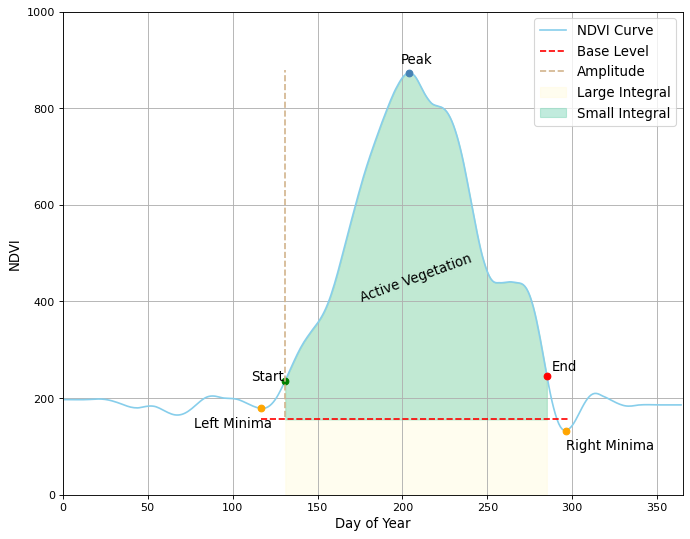

In [84]:
a=100
df1 = ndvi.iloc[:,a]
x = np.array(ndvi.iloc[int(np.array(ndvi.iloc[(ndvi.index==pheno_metrics.iloc[a,0]),a].index)):int(np.array(ndvi.iloc[(ndvi.index==pheno_metrics.iloc[a,2]),a].index))+1,a].index)
y = np.array(ndvi.iloc[(ndvi.index>=pheno_metrics.iloc[a,0]) & (ndvi.index<=pheno_metrics.iloc[a,2]),a])

plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(df1, marker=None, markerfacecolor='lightgreen', color='skyblue', label='NDVI Curve')
plt.plot(pheno_metrics.iloc[a,0],ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,0],a], marker='o', color='green')
plt.text(pheno_metrics.iloc[a,0]-20,ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,0],a],'Start',fontsize=12)

plt.plot(pheno_metrics.iloc[a,1],ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,1],a], marker='o', color='steelblue')
plt.text(pheno_metrics.iloc[a,1]-5,ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,1],a]+20,'Peak',fontsize=12)

plt.plot(pheno_metrics.iloc[a,2],ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,2],a], marker='o', color='red')
plt.text(pheno_metrics.iloc[a,2]+3,ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,2],a]+10,'End',fontsize=12)

plt.plot(t_left_min.iloc[a,0],t_left_min.iloc[a,1], marker='o', color='orange')
plt.text(t_left_min.iloc[a,0]-40,t_left_min.iloc[a,1]-40,'Left Minima',fontsize=12)
plt.plot(t_right_min.iloc[a,0],t_right_min.iloc[a,1], marker='o', color='orange')
plt.text(t_right_min.iloc[a,0],t_right_min.iloc[a,1]-40,'Right Minima',fontsize=12)

plt.fill_between(x, y, color='lemonchiffon', alpha=0.3, label='Large Integral')
plt.fill_between(x, y,(t_min.iloc[a,1]+t_min.iloc[a,3])/2, color='mediumaquamarine', alpha=0.4, label='Small Integral')

plt.text(pheno_metrics.iloc[a,1]-30,400,'Active Vegetation',rotation=20,fontsize=12)

plt.axhline((t_min.iloc[a,1]+t_min.iloc[a,3])/2, color='red', linestyle='--', xmin = 0.32, xmax=0.815, label='Base Level')
plt.axvline(pheno_metrics.iloc[a,0], color='tan', linestyle='--', ymin = 0.16, ymax=0.88, label='Amplitude')
plt.xlim(0,365)
plt.ylim(0,1000)
plt.xlabel('Day of Year',fontsize=12)
plt.ylabel('NDVI',fontsize=12)
plt.legend(fontsize = 12)
plt.grid()
plt.savefig('timesat.png', dpi=100)

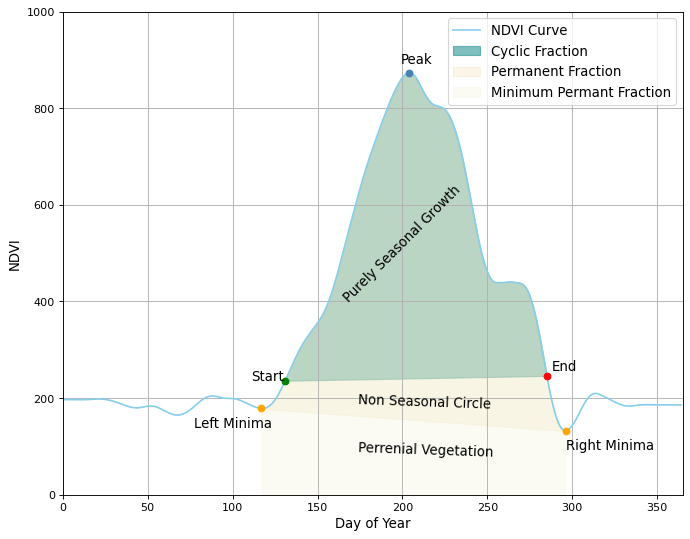

In [85]:
a=100
df1 = ndvi.iloc[:,a]
x = np.array(ndvi.iloc[int(np.array(ndvi.iloc[(ndvi.index==pheno_metrics.iloc[a,0]),a].index)):int(np.array(ndvi.iloc[(ndvi.index==pheno_metrics.iloc[a,2]),a].index))+1,a].index)
y = np.array(ndvi.iloc[(ndvi.index>=pheno_metrics.iloc[a,0]) & (ndvi.index<=pheno_metrics.iloc[a,2]),a])

slope = (int(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,0],a])-int(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,2],a]))/(pheno_metrics.iloc[a,0]-pheno_metrics.iloc[a,2])
b = (pheno_metrics.iloc[a,0]*int(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,2],a]) - pheno_metrics.iloc[a,2]*int(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,0],a]))/(pheno_metrics.iloc[a,0]-pheno_metrics.iloc[a,2])
k = slope*np.array(ndvi.iloc[int(np.array(ndvi.iloc[(ndvi.index==pheno_metrics.iloc[a,0]),a].index)):int(np.array(ndvi.iloc[(ndvi.index==pheno_metrics.iloc[a,2]),a].index))+1,a].index)+b

xn = np.array(ndvi.iloc[int(np.array(ndvi.iloc[(ndvi.index==t_left_min.iloc[a,0]),a].index)):int(np.array(ndvi.iloc[(ndvi.index==t_right_min.iloc[a,0]),a].index))+1,a].index)
yn = np.array(ndvi.iloc[(ndvi.index>=t_left_min.iloc[a,0]) & (ndvi.index<=t_right_min.iloc[a,0]),a])

slopen = (int(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==t_left_min.iloc[a,0],a])-int(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==t_right_min.iloc[a,0],a]))/(t_left_min.iloc[a,0]-t_right_min.iloc[a,0])
bn = (t_left_min.iloc[a,0]*int(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==t_right_min.iloc[a,0],a]) - t_right_min.iloc[a,0]*int(ndvi.iloc[np.array(ndvi.iloc[:,a].index)==t_left_min.iloc[a,0],a]))/(t_left_min.iloc[a,0]-t_right_min.iloc[a,0])
kn = slopen*np.array(ndvi.iloc[int(np.array(ndvi.iloc[(ndvi.index==t_left_min.iloc[a,0]),a].index)):int(np.array(ndvi.iloc[(ndvi.index==t_right_min.iloc[a,0]),a].index))+1,a].index)+bn



plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(df1, marker=None, markerfacecolor='lightgreen', color='skyblue', label='NDVI Curve')

plt.plot(pheno_metrics.iloc[a,0],ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,0],a], marker='o', color='green')
plt.text(pheno_metrics.iloc[a,0]-20,ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,0],a],'Start',fontsize=12)

plt.plot(pheno_metrics.iloc[a,1],ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,1],a], marker='o', color='steelblue')
plt.text(pheno_metrics.iloc[a,1]-5,ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,1],a]+20,'Peak',fontsize=12)

plt.plot(pheno_metrics.iloc[a,2],ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,2],a], marker='o', color='red')
plt.text(pheno_metrics.iloc[a,2]+3,ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,2],a]+10,'End',fontsize=12)

plt.plot(t_left_min.iloc[a,0],t_left_min.iloc[a,1], marker='o', color='orange')
plt.text(t_left_min.iloc[a,0]-40,t_left_min.iloc[a,1]-40,'Left Minima',fontsize=12)
plt.plot(t_right_min.iloc[a,0],t_right_min.iloc[a,1], marker='o', color='orange')
plt.text(t_right_min.iloc[a,0],t_right_min.iloc[a,1]-40,'Right Minima',fontsize=12)

plt.fill_between(x, y, k, color='teal', alpha=0.5, label='Cyclic Fraction')
plt.fill_between(xn, yn,kn, color='wheat', alpha=0.3, label='Permanent Fraction')
plt.fill_between(xn, yn, color='beige', alpha=0.3, label='Minimum Permant Fraction')

plt.text(pheno_metrics.iloc[a,1]-40,400,'Purely Seasonal Growth',rotation=45,fontsize=12)
plt.text(pheno_metrics.iloc[a,1]-30,180,'Non Seasonal Circle',rotation=-2,fontsize=12)
plt.text(pheno_metrics.iloc[a,1]-30,80,'Perrenial Vegetation',rotation=-2,fontsize=12)

plt.xlim(0,365)
plt.ylim(0,1000)
plt.xlabel('Day of Year',fontsize=12)
plt.ylabel('NDVI',fontsize=12)
plt.legend(fontsize = 12)
plt.grid()
plt.savefig('fenicephenolo.png', dpi=100)

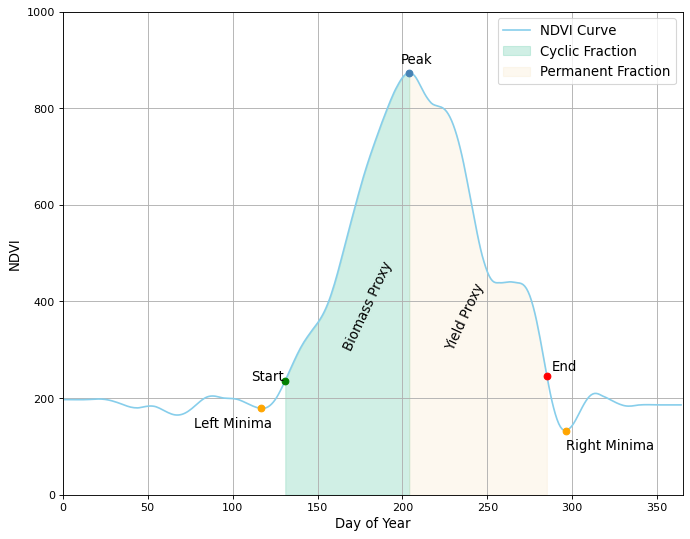

In [86]:
a=100
df1 = ndvi.iloc[:,a]
x = np.array(ndvi.iloc[int(np.array(ndvi.iloc[(ndvi.index==pheno_metrics.iloc[a,0]),a].index)):int(np.array(ndvi.iloc[(ndvi.index==pheno_metrics.iloc[a,1]),a].index))+1,a].index)
y = np.array(ndvi.iloc[(ndvi.index>=pheno_metrics.iloc[a,0]) & (ndvi.index<=pheno_metrics.iloc[a,1]),a])

xn = np.array(ndvi.iloc[int(np.array(ndvi.iloc[(ndvi.index==pheno_metrics.iloc[a,1]),a].index)):int(np.array(ndvi.iloc[(ndvi.index==pheno_metrics.iloc[a,2]),a].index))+1,a].index)
yn = np.array(ndvi.iloc[(ndvi.index>=pheno_metrics.iloc[a,1]) & (ndvi.index<=pheno_metrics.iloc[a,2]),a])



plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(df1, marker=None, markerfacecolor='lightgreen', color='skyblue', label='NDVI Curve')
plt.plot(pheno_metrics.iloc[a,0],ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,0],a], marker='o', color='green')
plt.text(pheno_metrics.iloc[a,0]-20,ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,0],a],'Start',fontsize=12)

plt.plot(pheno_metrics.iloc[a,1],ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,1],a], marker='o', color='steelblue')
plt.text(pheno_metrics.iloc[a,1]-5,ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,1],a]+20,'Peak',fontsize=12)

plt.plot(pheno_metrics.iloc[a,2],ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,2],a], marker='o', color='red')
plt.text(pheno_metrics.iloc[a,2]+3,ndvi.iloc[np.array(ndvi.iloc[:,a].index)==pheno_metrics.iloc[a,2],a]+10,'End',fontsize=12)

plt.plot(t_left_min.iloc[a,0],t_left_min.iloc[a,1], marker='o', color='orange')
plt.text(t_left_min.iloc[a,0]-40,t_left_min.iloc[a,1]-40,'Left Minima',fontsize=12)
plt.plot(t_right_min.iloc[a,0],t_right_min.iloc[a,1], marker='o', color='orange')
plt.text(t_right_min.iloc[a,0],t_right_min.iloc[a,1]-40,'Right Minima',fontsize=12)

plt.fill_between(x, y,  color='mediumaquamarine', alpha=0.3, label='Cyclic Fraction')
plt.fill_between(xn, yn, color='wheat', alpha=0.2, label='Permanent Fraction')

plt.text(pheno_metrics.iloc[a,1]-40,300,'Biomass Proxy',rotation=65,fontsize=12)
plt.text(pheno_metrics.iloc[a,1]+20,300,'Yield Proxy',rotation=65,fontsize=12)

plt.xlim(0,365)
plt.ylim(0,1000)
plt.xlabel('Day of Year',fontsize=12)
plt.ylabel('NDVI',fontsize=12)
plt.legend(fontsize = 12)
plt.grid()
plt.savefig('crophenology.png', dpi=100)